In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from model.bulkformer import BulkFormer, model_params

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [3]:
ckpt_path = "bulkformer_checkpoints/epoch_4.pt"   # or whichever epoch you want
state_dict = torch.load(ckpt_path, map_location="cpu")

import json

with open("bulkformer_checkpoints/config.json", "r") as f:
    cfg = json.load(f)

cfg

esm2_data = torch.load("./data/embeddings/esm2_t6_8M_UR50D_gene_embeddings.pt")
gene_emb = esm2_data["embeddings"].float()

edge_index = torch.load("./graph/edge_index_top20.pt").long()

In [4]:
model = BulkFormer(
    dim=cfg["dim"],
    graph=edge_index,                # You need to load this (see below)
    gene_emb=gene_emb,             # And this
    gene_length=cfg["num_genes"],
    bin_head=cfg["bin_head"],
    full_head=cfg["full_head"],
    bins=cfg["bins"],
    gb_repeat=cfg["gb_repeat"],
    p_repeat=cfg["p_repeat"],
)



In [5]:
model.load_state_dict(state_dict)
model = model.to("cuda")



In [6]:

with torch.no_grad():
    # gene identity embedding only
    gene_embed = model.gene_emb_proj(model.gene_emb)  # shape (19357, 320)

gene_embed = gene_embed.cpu().numpy()
gene_embed.shape



(19357, 320)

In [7]:
tsne = TSNE(
    n_components=2,
    learning_rate="auto",
    init="random",
    perplexity=30,
    random_state=42
)

tsne_emb = tsne.fit_transform(gene_embed)
tsne_emb.shape


(19357, 2)

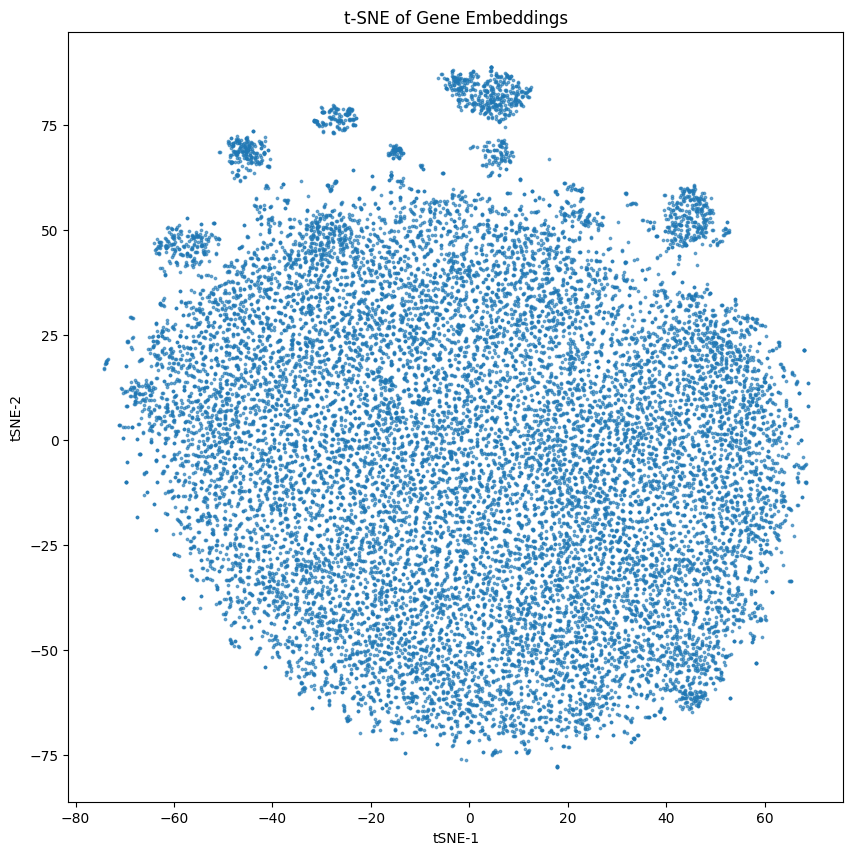

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s=3, alpha=0.6)
plt.title("t-SNE of Gene Embeddings")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()


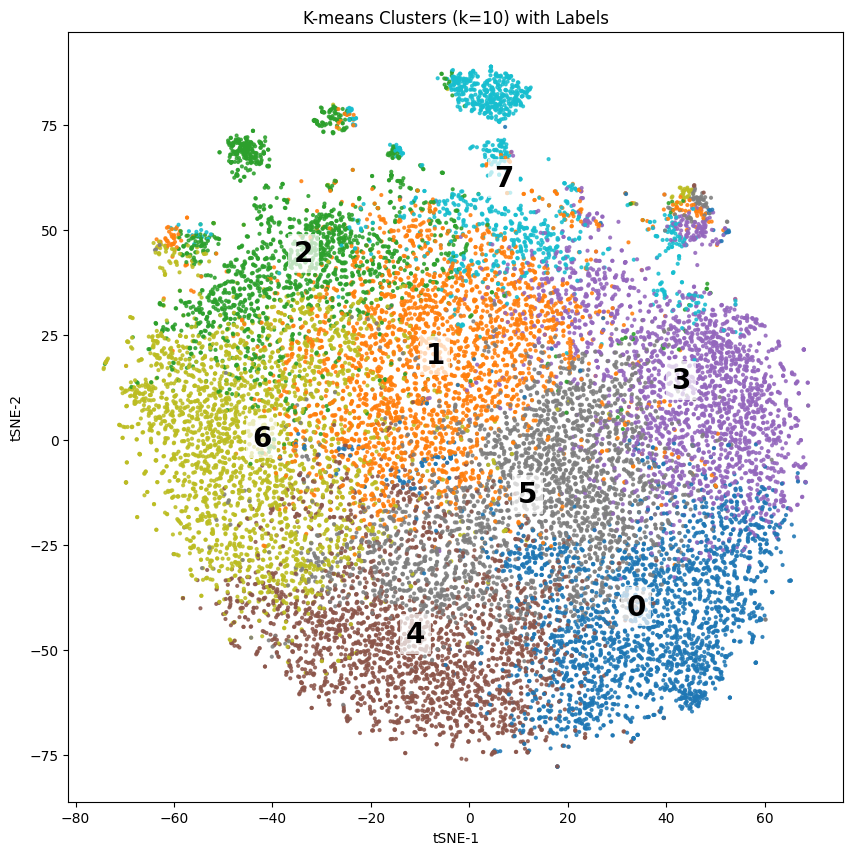

In [9]:
k = 8  # number of clusters
km = KMeans(n_clusters=k, random_state=42)
clusters = km.fit_predict(gene_embed)

clusters[:20]

plt.figure(figsize=(10,10))

# Scatter points
plt.scatter(
    tsne_emb[:,0], tsne_emb[:,1],
    c=clusters,
    cmap="tab10",
    s=4,
    alpha=0.8
)

# Add cluster labels at the cluster centroid
for c in range(k):
    cx = tsne_emb[clusters == c, 0].mean()
    cy = tsne_emb[clusters == c, 1].mean()
    plt.text(
        cx, cy, str(c),
        fontsize=20, fontweight="bold",
        color="black",
        ha="center", va="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor='none')
    )

plt.title("K-means Clusters (k=10) with Labels")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()



/home/walt/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/walt/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


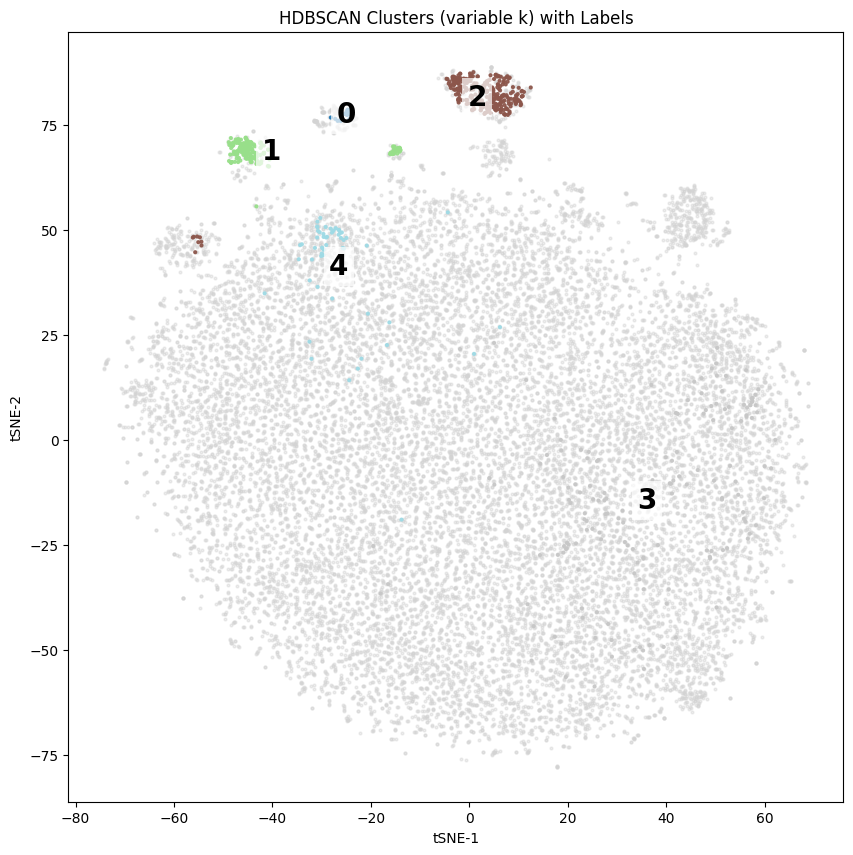

In [10]:
import hdbscan

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='leaf',   
)
clusters = clusterer.fit_predict(gene_embed)
clusters[:20]

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))

# Mask noise points (-1)
is_noise = clusters == -1
is_cluster = clusters != -1

# Plot noise in light gray
plt.scatter(
    tsne_emb[is_noise, 0],
    tsne_emb[is_noise, 1],
    c='lightgray',
    s=4,
    alpha=0.4,
    label='Noise'
)

# Plot clusters
plt.scatter(
    tsne_emb[is_cluster, 0],
    tsne_emb[is_cluster, 1],
    c=clusters[is_cluster],
    cmap='tab20',
    s=4,
    alpha=0.9
)

# Get number of clusters (excluding noise)
unique_clusters = [c for c in np.unique(clusters) if c != -1]

# Add cluster labels at centroid of each cluster
for c in unique_clusters:
    cx = tsne_emb[clusters == c, 0].mean()
    cy = tsne_emb[clusters == c, 1].mean()
    
    plt.text(
        cx, cy, str(c),
        fontsize=20, fontweight="bold",
        color="black",
        ha="center", va="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor='none')
    )

plt.title("HDBSCAN Clusters (variable k) with Labels")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()



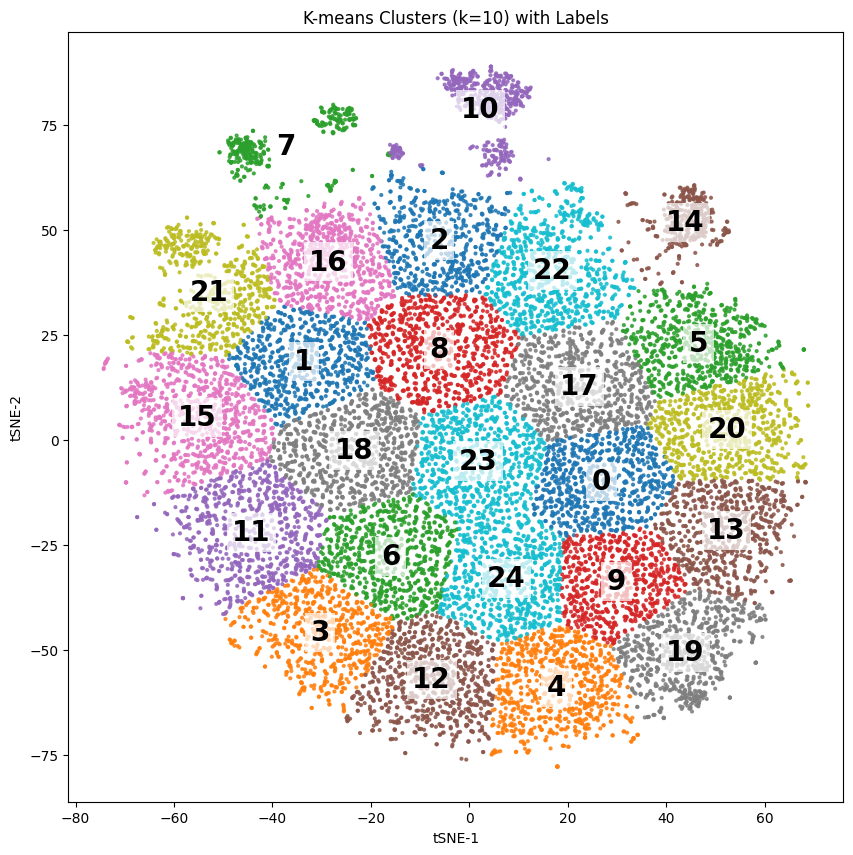

In [11]:
from sklearn.cluster import KMeans
import numpy as np

k = 25  # number of clusters

km = KMeans(
    n_clusters=k,
    init='k-means++',
    random_state=42,
    max_iter=300,
    n_init=10,                    
)
clusters = km.fit_predict(tsne_emb)

plt.figure(figsize=(10,10))

# Scatter points
plt.scatter(
    tsne_emb[:,0], tsne_emb[:,1],
    c=clusters,
    cmap="tab10",
    s=4,
    alpha=0.8
)

# Add cluster labels at the cluster centroid
for c in range(k):
    cx = tsne_emb[clusters == c, 0].mean()
    cy = tsne_emb[clusters == c, 1].mean()
    plt.text(
        cx, cy, str(c),
        fontsize=20, fontweight="bold",
        color="black",
        ha="center", va="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor='none')
    )

plt.title("K-means Clusters (k=10) with Labels")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()



In [12]:
# load the gene order file from training if you have one
gene_order = pd.read_csv("./data/archs4/processed_short_proteins/test_gene_order_short.csv")

print("Columns:", gene_order.columns.tolist())
print(gene_order.head(10))

gene_names = gene_order["gene_symbol"].tolist()

len(gene_names)


Columns: ['gene_symbol']
  gene_symbol
0      MT-ND1
1      MT-ND2
2      MT-CO1
3      MT-CO2
4     MT-ATP8
5     MT-ATP6
6      MT-CO3
7      MT-ND3
8     MT-ND4L
9      MT-ND4


19357

In [13]:
enrichment_results = {}

for c in range(k):
    gene_list = [gene_names[i] for i in range(len(gene_names)) if clusters[i] == c]

    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets=["GO_Biological_Process_2021"],
        organism="Human",
        cutoff=0.05
    )
    
    enrichment_results[c] = enr.results
    print(f"Cluster {c}: {len(enr.results)} significant GO terms")


Cluster 0: 2981 significant GO terms
Cluster 1: 2683 significant GO terms
Cluster 2: 1875 significant GO terms
Cluster 3: 3044 significant GO terms
Cluster 4: 3598 significant GO terms
Cluster 5: 2272 significant GO terms
Cluster 6: 3114 significant GO terms
Cluster 7: 165 significant GO terms
Cluster 8: 3067 significant GO terms
Cluster 9: 3018 significant GO terms
Cluster 10: 511 significant GO terms
Cluster 11: 3170 significant GO terms
Cluster 12: 3423 significant GO terms
Cluster 13: 3044 significant GO terms
Cluster 14: 331 significant GO terms
Cluster 15: 3004 significant GO terms
Cluster 16: 2033 significant GO terms
Cluster 17: 2479 significant GO terms
Cluster 18: 3367 significant GO terms
Cluster 19: 2958 significant GO terms
Cluster 20: 2874 significant GO terms
Cluster 21: 1901 significant GO terms
Cluster 22: 2528 significant GO terms
Cluster 23: 3303 significant GO terms
Cluster 24: 3302 significant GO terms


In [14]:
kegg_results = {}

for c in range(k):
    gene_list = [gene_names[i] for i in range(len(gene_names)) if clusters[i] == c]

    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets=["KEGG_2021_Human"],
        organism="Human",
        cutoff=0.05
    )
    
    kegg_results[c] = enr.results
    print(f"Cluster {c}: {len(enr.results)} KEGG pathways")


Cluster 0: 262 KEGG pathways
Cluster 1: 275 KEGG pathways
Cluster 2: 218 KEGG pathways
Cluster 3: 274 KEGG pathways
Cluster 4: 295 KEGG pathways
Cluster 5: 248 KEGG pathways
Cluster 6: 273 KEGG pathways
Cluster 7: 22 KEGG pathways
Cluster 8: 271 KEGG pathways
Cluster 9: 274 KEGG pathways
Cluster 10: 52 KEGG pathways
Cluster 11: 267 KEGG pathways
Cluster 12: 293 KEGG pathways
Cluster 13: 265 KEGG pathways
Cluster 14: 24 KEGG pathways
Cluster 15: 267 KEGG pathways
Cluster 16: 233 KEGG pathways
Cluster 17: 266 KEGG pathways
Cluster 18: 278 KEGG pathways
Cluster 19: 264 KEGG pathways
Cluster 20: 248 KEGG pathways
Cluster 21: 203 KEGG pathways
Cluster 22: 239 KEGG pathways
Cluster 23: 275 KEGG pathways
Cluster 24: 291 KEGG pathways


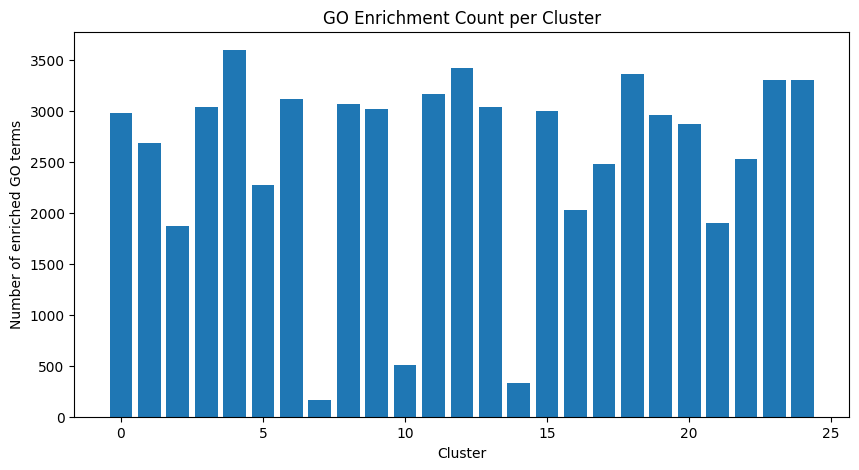

In [15]:
go_counts = [len(enrichment_results[c]) for c in range(k)]

plt.figure(figsize=(10,5))
plt.bar(range(k), go_counts)
plt.xlabel("Cluster")
plt.ylabel("Number of enriched GO terms")
plt.title("GO Enrichment Count per Cluster")
plt.show()


In [16]:
def compute_rich_factor(df):
    rf = []
    for s in df["Overlap"]:
        a, b = s.split("/")
        rf.append(int(a) / int(b))
    return np.array(rf)


In [17]:
cell_cycle_terms = [
    "cell cycle",
    "mitotic",
    "chromosome",
    "DNA replication",
    "splicing",
    "RNA splicing",
    "DNA repair",
    "cell division",
    "chromatin organization"
]


immune_terms = [
    "immune",
    "defense",
    "antigen",
    "interferon",
    "T cell",
    "B cell",
    "inflammatory",
    "cytokine",
    "pathogen",
    "response to bacterium",
]

import re

def count_matches(df, keywords):
    if df is None or len(df) == 0:
        return 0
    pattern = "|".join([re.escape(k) for k in keywords])
    return df["Term"].str.contains(pattern, case=False, regex=True).sum()

cluster_theme_scores = {}

for c in range(k):
    df = enrichment_results[c]
    
    score_cellcycle = count_matches(df, cell_cycle_terms)
    score_immune    = count_matches(df, immune_terms)
    
    cluster_theme_scores[c] = {
        "cell_cycle_score": score_cellcycle,
        "immune_score": score_immune,
        "n_terms": len(df)
    }

cluster_theme_scores



{0: {'cell_cycle_score': np.int64(124),
  'immune_score': np.int64(170),
  'n_terms': 2981},
 1: {'cell_cycle_score': np.int64(40),
  'immune_score': np.int64(220),
  'n_terms': 2683},
 2: {'cell_cycle_score': np.int64(22),
  'immune_score': np.int64(140),
  'n_terms': 1875},
 3: {'cell_cycle_score': np.int64(67),
  'immune_score': np.int64(159),
  'n_terms': 3044},
 4: {'cell_cycle_score': np.int64(115),
  'immune_score': np.int64(212),
  'n_terms': 3598},
 5: {'cell_cycle_score': np.int64(137),
  'immune_score': np.int64(136),
  'n_terms': 2272},
 6: {'cell_cycle_score': np.int64(77),
  'immune_score': np.int64(137),
  'n_terms': 3114},
 7: {'cell_cycle_score': np.int64(3),
  'immune_score': np.int64(11),
  'n_terms': 165},
 8: {'cell_cycle_score': np.int64(75),
  'immune_score': np.int64(177),
  'n_terms': 3067},
 9: {'cell_cycle_score': np.int64(117),
  'immune_score': np.int64(160),
  'n_terms': 3018},
 10: {'cell_cycle_score': np.int64(4),
  'immune_score': np.int64(70),
  'n_ter

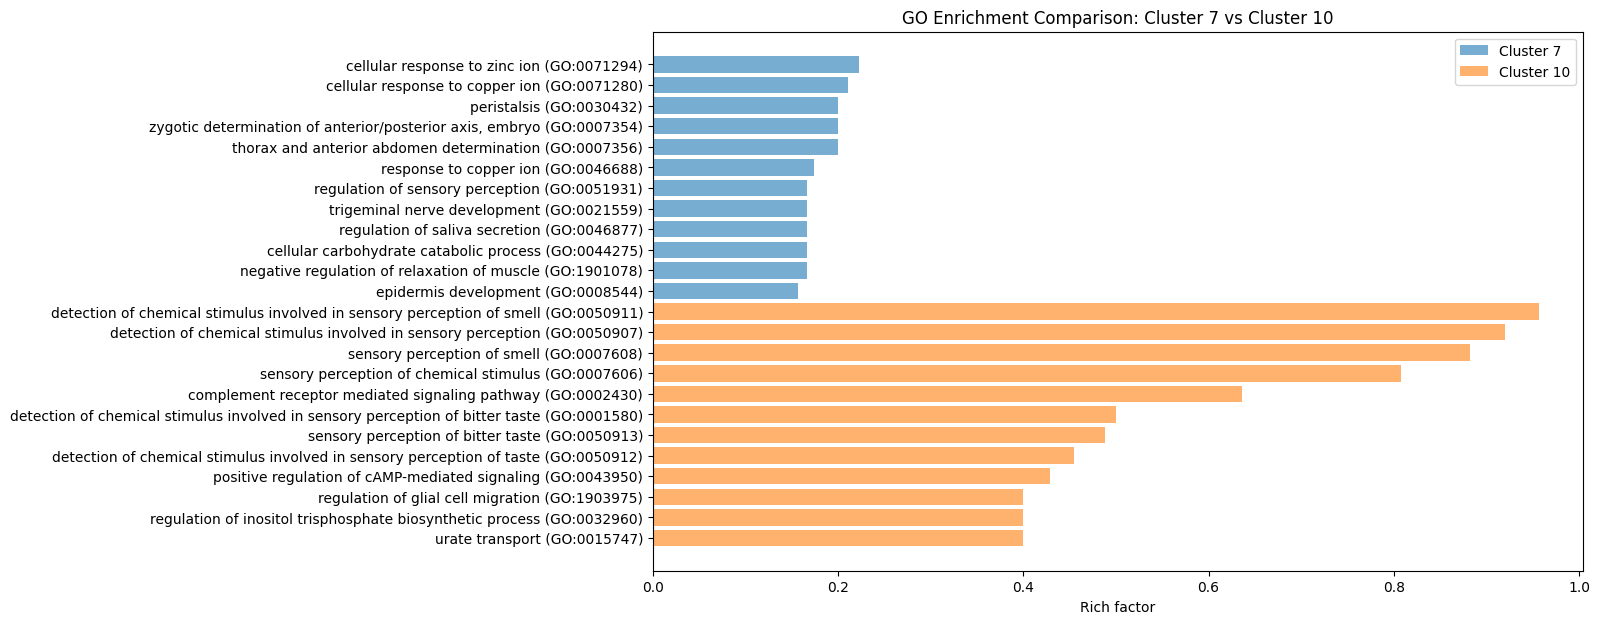


Top 5 GO terms for Cluster 7:
1. cellular response to zinc ion (GO:0071294) (rich factor = 0.222)
2. cellular response to copper ion (GO:0071280) (rich factor = 0.211)
3. peristalsis (GO:0030432) (rich factor = 0.200)
4. zygotic determination of anterior/posterior axis, embryo (GO:0007354) (rich factor = 0.200)
5. thorax and anterior abdomen determination (GO:0007356) (rich factor = 0.200)

Top 5 GO terms for Cluster 10:
1. detection of chemical stimulus involved in sensory perception of smell (GO:0050911) (rich factor = 0.957)
2. detection of chemical stimulus involved in sensory perception (GO:0050907) (rich factor = 0.920)
3. sensory perception of smell (GO:0007608) (rich factor = 0.883)
4. sensory perception of chemical stimulus (GO:0007606) (rich factor = 0.808)
5. complement receptor mediated signaling pathway (GO:0002430) (rich factor = 0.636)


In [27]:
c1, c2 = 7, 10

df1 = enrichment_results[c1].copy()
df2 = enrichment_results[c2].copy()

df1["rich_factor"] = compute_rich_factor(df1)
df2["rich_factor"] = compute_rich_factor(df2)

# Top 12 for clean plot
df1_top = df1.nlargest(12, "rich_factor")
df2_top = df2.nlargest(12, "rich_factor")

plt.figure(figsize=(12,7))
plt.barh(df1_top["Term"], df1_top["rich_factor"], alpha=0.6, label=f"Cluster {c1}")
plt.barh(df2_top["Term"], df2_top["rich_factor"], alpha=0.6, label=f"Cluster {c2}")
plt.xlabel("Rich factor")
plt.title(f"GO Enrichment Comparison: Cluster {c1} vs Cluster {c2}")
plt.legend()
plt.gca().invert_yaxis()
plt.show()


print(f"\nTop 5 GO terms for Cluster {c1}:")
for i, (term, rf) in enumerate(zip(df1_top["Term"].head(5),
                                   df1_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")

print(f"\nTop 5 GO terms for Cluster {c2}:")
for i, (term, rf) in enumerate(zip(df2_top["Term"].head(5),
                                   df2_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")


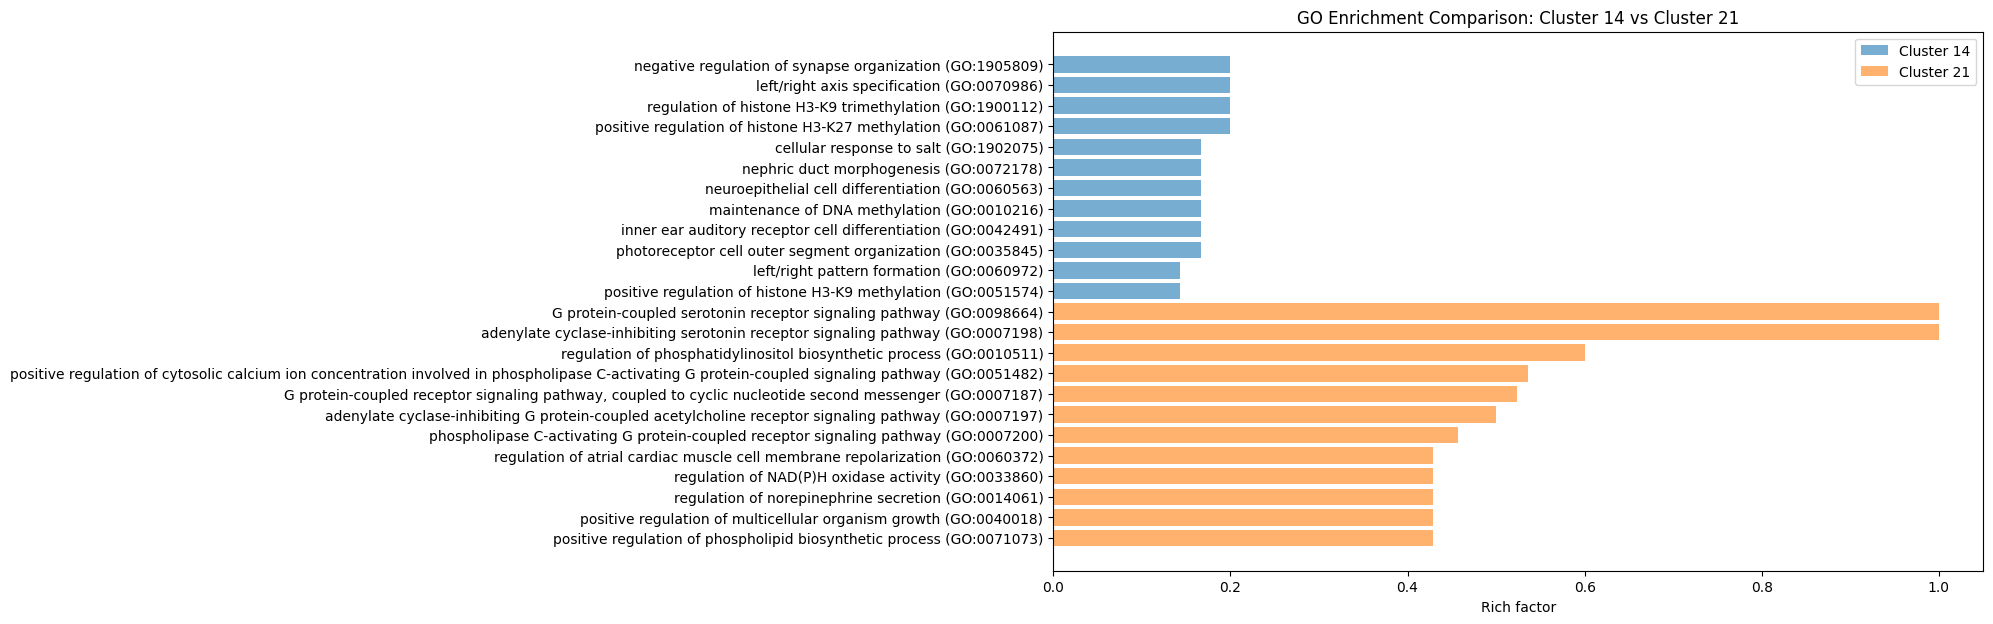


Top 5 GO terms for Cluster 14:
1. negative regulation of synapse organization (GO:1905809) (rich factor = 0.200)
2. left/right axis specification (GO:0070986) (rich factor = 0.200)
3. regulation of histone H3-K9 trimethylation (GO:1900112) (rich factor = 0.200)
4. positive regulation of histone H3-K27 methylation (GO:0061087) (rich factor = 0.200)
5. cellular response to salt (GO:1902075) (rich factor = 0.167)

Top 5 GO terms for Cluster 21:
1. G protein-coupled serotonin receptor signaling pathway (GO:0098664) (rich factor = 1.000)
2. adenylate cyclase-inhibiting serotonin receptor signaling pathway (GO:0007198) (rich factor = 1.000)
3. regulation of phosphatidylinositol biosynthetic process (GO:0010511) (rich factor = 0.600)
4. positive regulation of cytosolic calcium ion concentration involved in phospholipase C-activating G protein-coupled signaling pathway (GO:0051482) (rich factor = 0.536)
5. G protein-coupled receptor signaling pathway, coupled to cyclic nucleotide second messe

In [29]:
c1, c2 = 14, 21

df1 = enrichment_results[c1].copy()
df2 = enrichment_results[c2].copy()

df1["rich_factor"] = compute_rich_factor(df1)
df2["rich_factor"] = compute_rich_factor(df2)

# Top 12 for clean plot
df1_top = df1.nlargest(12, "rich_factor")
df2_top = df2.nlargest(12, "rich_factor")

plt.figure(figsize=(12,7))
plt.barh(df1_top["Term"], df1_top["rich_factor"], alpha=0.6, label=f"Cluster {c1}")
plt.barh(df2_top["Term"], df2_top["rich_factor"], alpha=0.6, label=f"Cluster {c2}")
plt.xlabel("Rich factor")
plt.title(f"GO Enrichment Comparison: Cluster {c1} vs Cluster {c2}")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

print(f"\nTop 5 GO terms for Cluster {c1}:")
for i, (term, rf) in enumerate(zip(df1_top["Term"].head(5),
                                   df1_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")

print(f"\nTop 5 GO terms for Cluster {c2}:")
for i, (term, rf) in enumerate(zip(df2_top["Term"].head(5),
                                   df2_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")



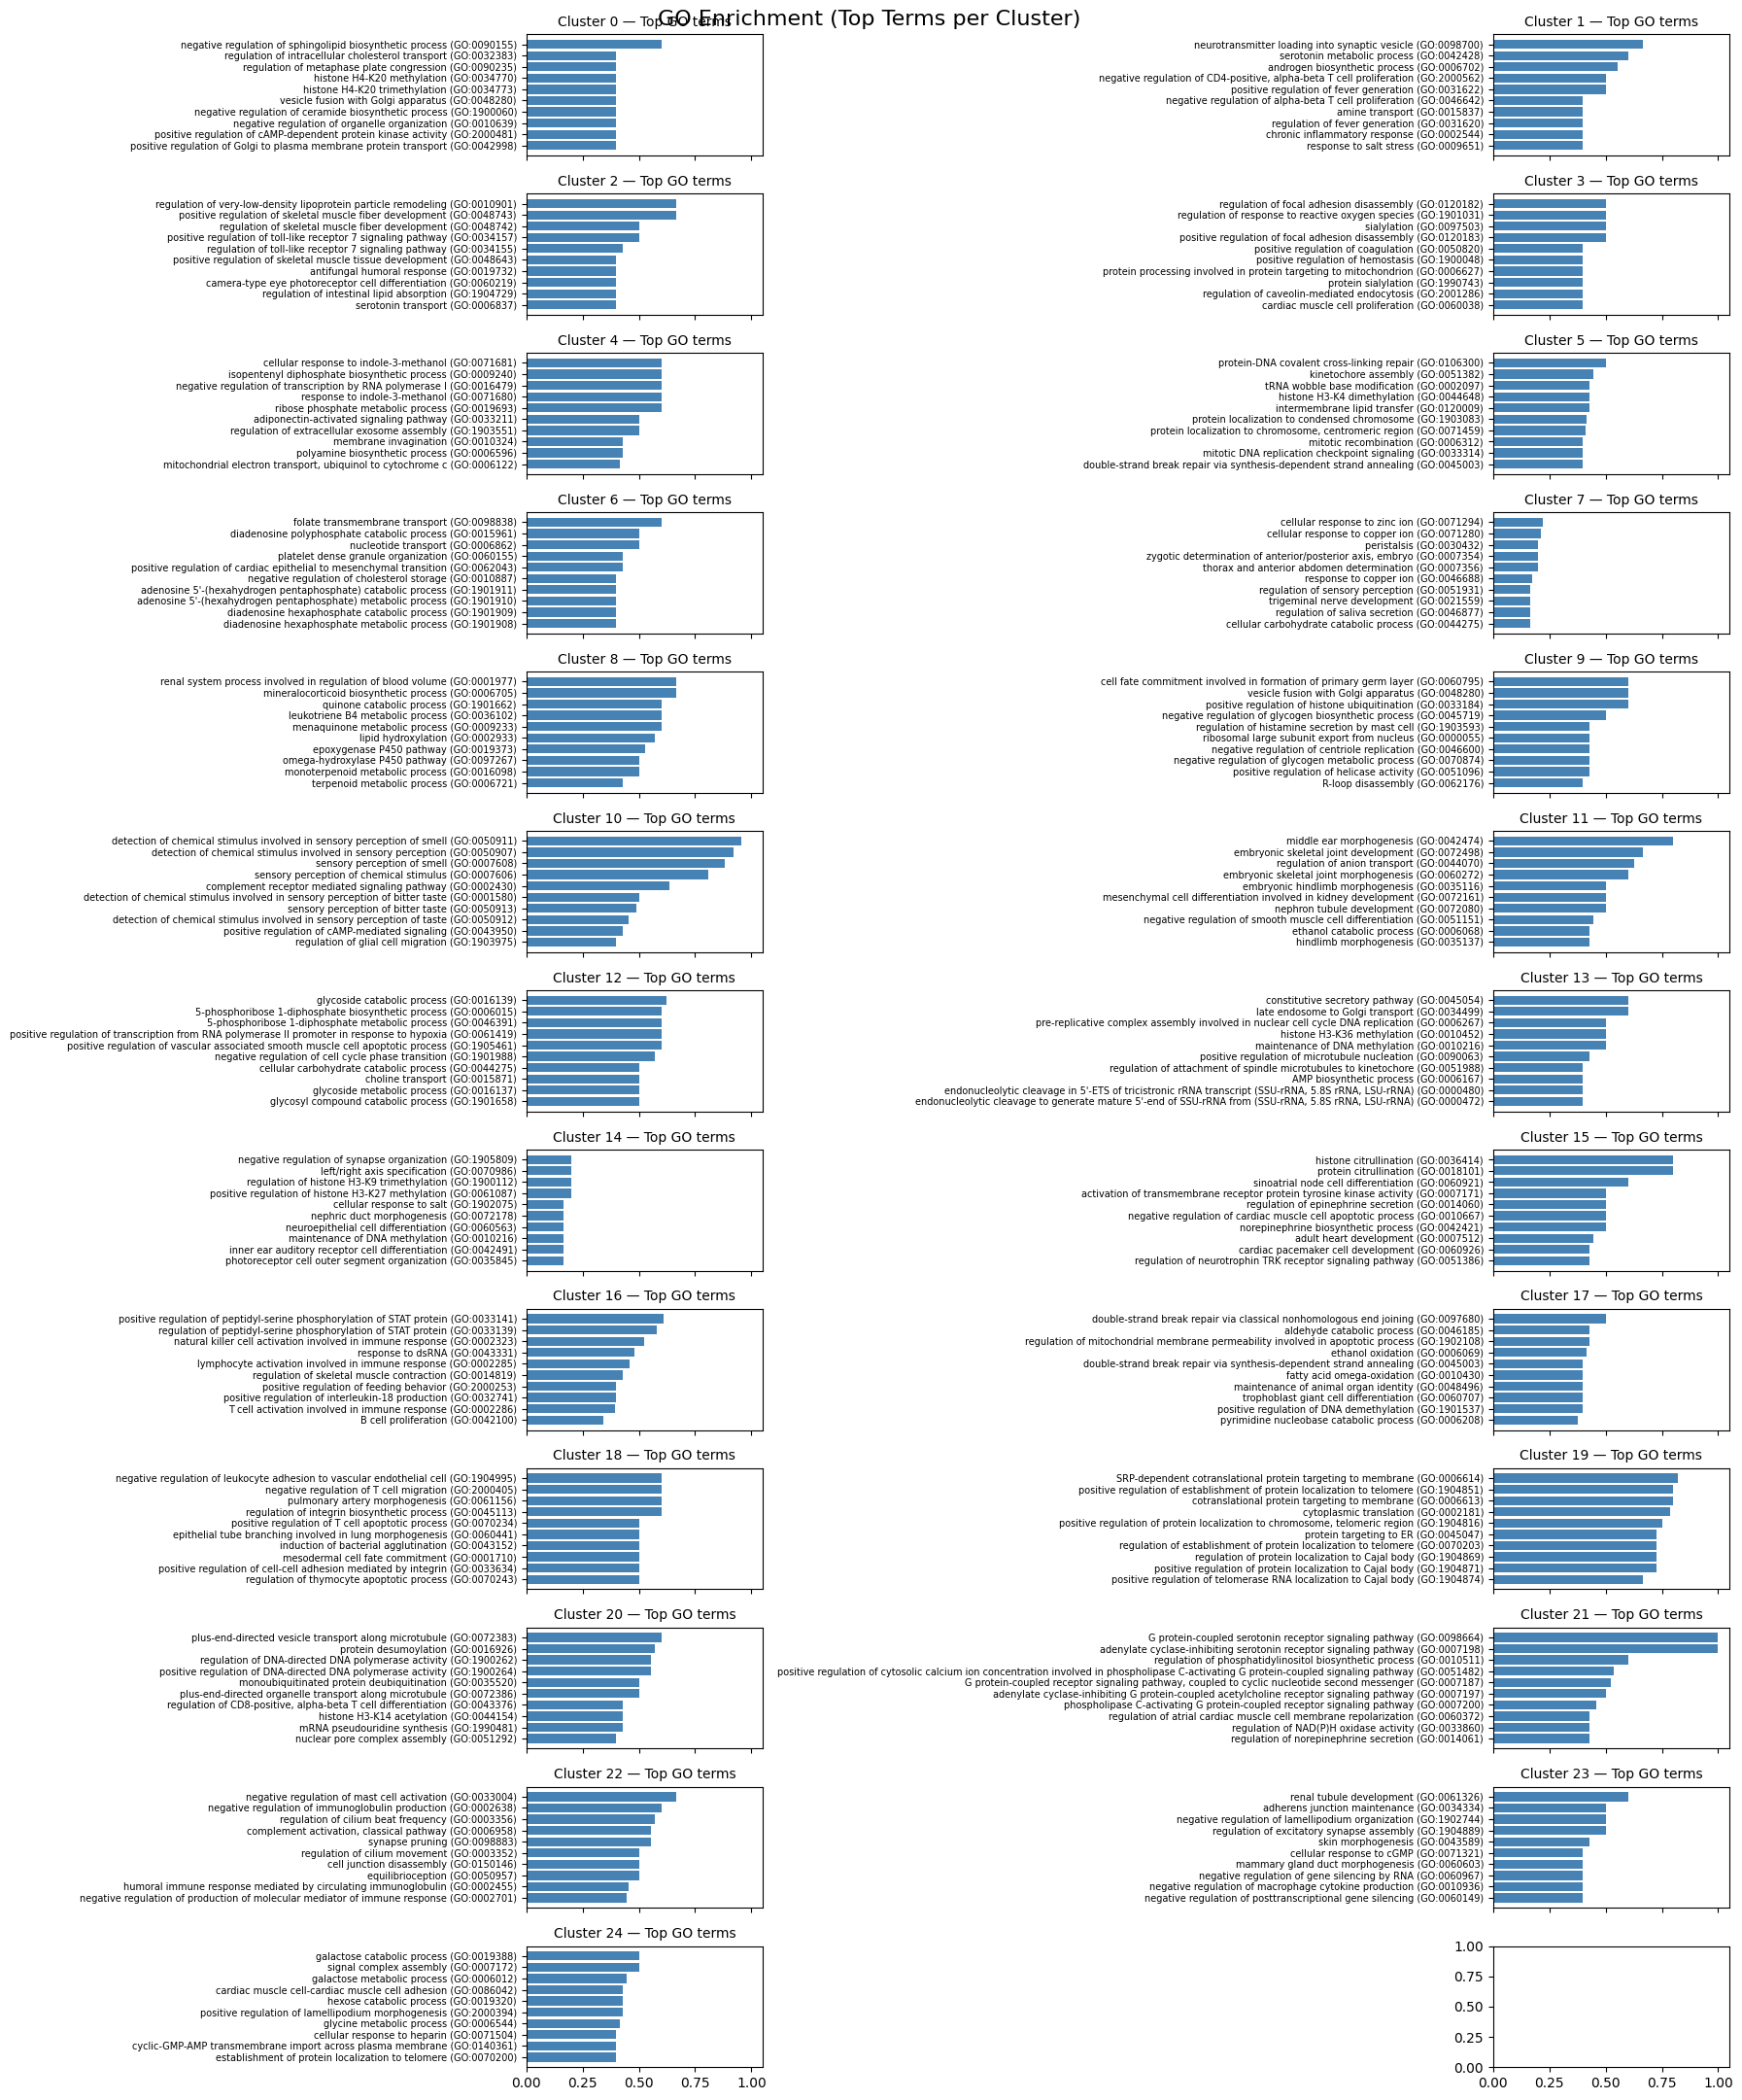

In [20]:
import matplotlib.pyplot as plt

# Prepare cluster → df mapping
cluster_top = {}

for c in range(k):
    df = enrichment_results[c].copy()
    df["rich_factor"] = compute_rich_factor(df)

    # keep top N
    df_top = df.nlargest(10, "rich_factor")
    cluster_top[c] = df_top

# Plot
rows = (k + 2) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(18, 22), sharex=True)

for idx, c in enumerate(range(k)):
    ax = axes[idx // cols][idx % cols]
    df = cluster_top[c]

    ax.barh(df["Term"], df["rich_factor"], color="steelblue")
    ax.set_title(f"Cluster {c} — Top GO terms", fontsize=10)
    ax.invert_yaxis()
    ax.tick_params(axis='y', labelsize=7)

fig.suptitle("GO Enrichment (Top Terms per Cluster)", fontsize=16)
plt.tight_layout()
plt.show()


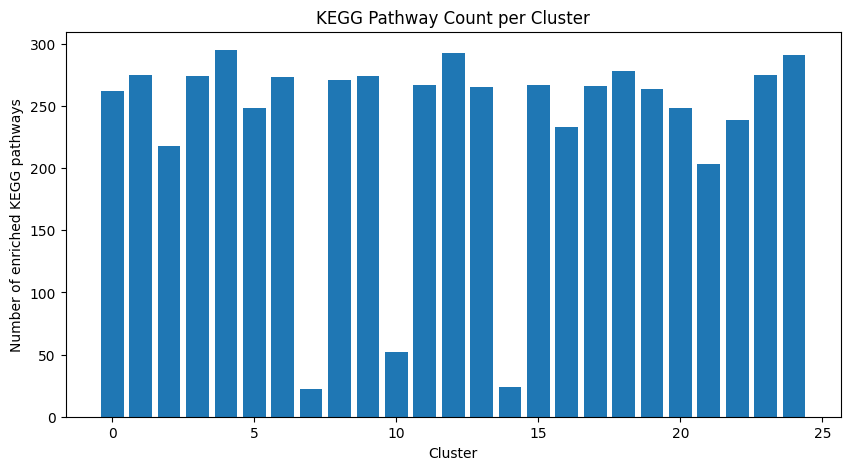

In [21]:
kegg_counts = [len(kegg_results[c]) for c in range(k)]

plt.figure(figsize=(10,5))
plt.bar(range(k), kegg_counts)
plt.xlabel("Cluster")
plt.ylabel("Number of enriched KEGG pathways")
plt.title("KEGG Pathway Count per Cluster")
plt.show()


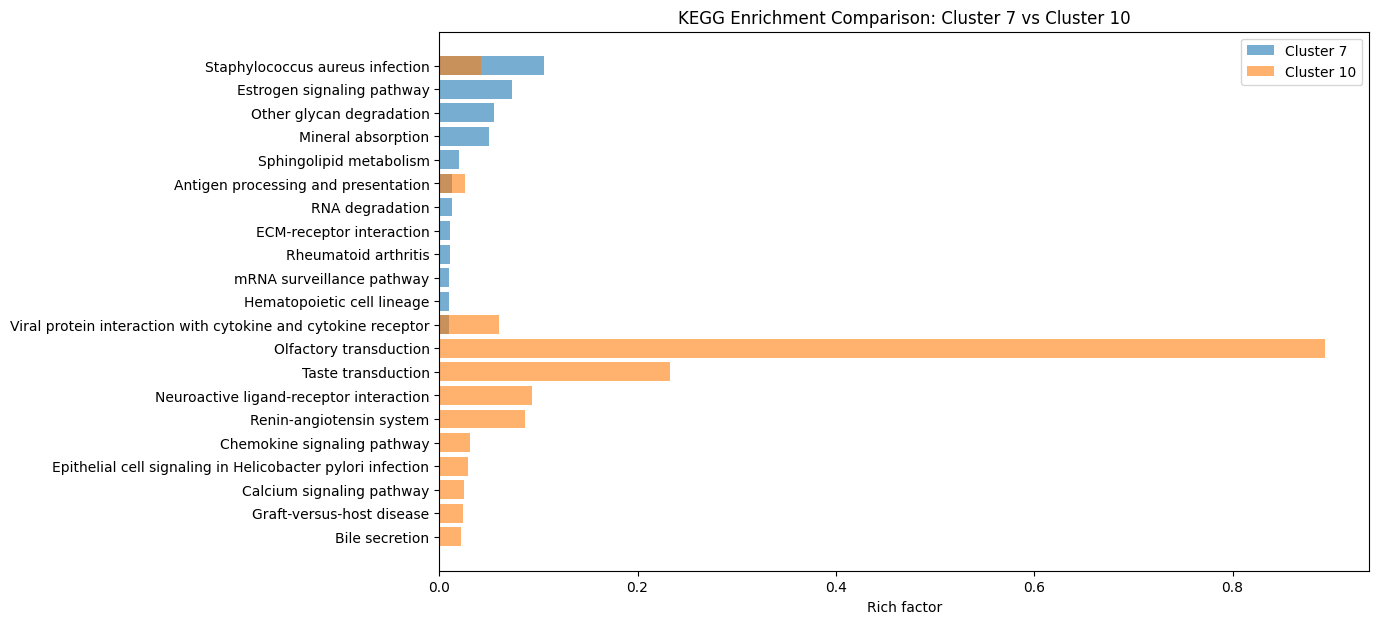


Top 5 KEGG terms for Cluster 7:
1. Staphylococcus aureus infection (rich factor = 0.105)
2. Estrogen signaling pathway (rich factor = 0.073)
3. Other glycan degradation (rich factor = 0.056)
4. Mineral absorption (rich factor = 0.050)
5. Sphingolipid metabolism (rich factor = 0.020)

Top 5 KEGG terms for Cluster 10:
1. Olfactory transduction (rich factor = 0.893)
2. Taste transduction (rich factor = 0.233)
3. Neuroactive ligand-receptor interaction (rich factor = 0.094)
4. Renin-angiotensin system (rich factor = 0.087)
5. Viral protein interaction with cytokine and cytokine receptor (rich factor = 0.060)


In [31]:
def compute_kegg_rich_factor(df):
    rf = []
    for s in df["Overlap"]:
        a, b = s.split("/")
        rf.append(int(a) / int(b))
    return np.array(rf)


c1, c2 = 7, 10

df1 = kegg_results[c1].copy()
df2 = kegg_results[c2].copy()

df1["rich_factor"] = compute_kegg_rich_factor(df1)
df2["rich_factor"] = compute_kegg_rich_factor(df2)

df1_top = df1.nlargest(12, "rich_factor")
df2_top = df2.nlargest(12, "rich_factor")

plt.figure(figsize=(12,7))
plt.barh(df1_top["Term"], df1_top["rich_factor"], alpha=0.6, label=f"Cluster {c1}")
plt.barh(df2_top["Term"], df2_top["rich_factor"], alpha=0.6, label=f"Cluster {c2}")
plt.xlabel("Rich factor")
plt.title(f"KEGG Enrichment Comparison: Cluster {c1} vs Cluster {c2}")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

print(f"\nTop 5 KEGG terms for Cluster {c1}:")
for i, (term, rf) in enumerate(zip(df1_top["Term"].head(5),
                                   df1_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")

print(f"\nTop 5 KEGG terms for Cluster {c2}:")
for i, (term, rf) in enumerate(zip(df2_top["Term"].head(5),
                                   df2_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")


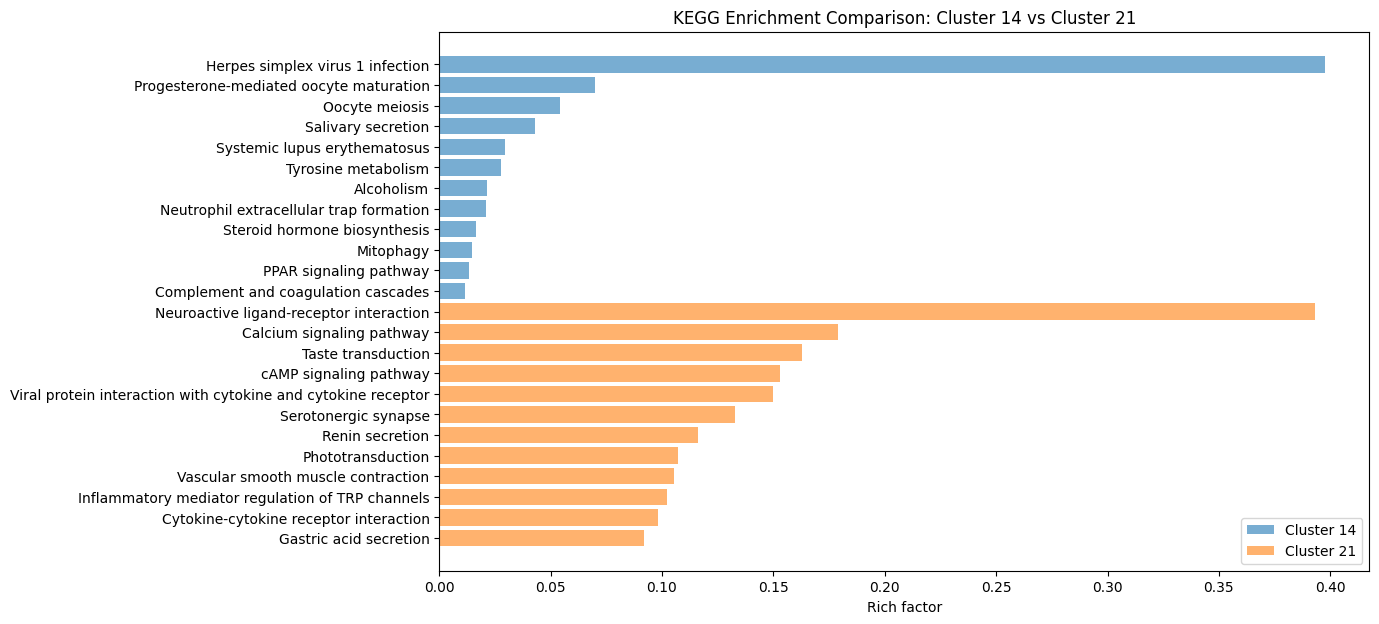


Top 5 KEGG terms for Cluster 14:
1. Herpes simplex virus 1 infection (rich factor = 0.398)
2. Progesterone-mediated oocyte maturation (rich factor = 0.070)
3. Oocyte meiosis (rich factor = 0.054)
4. Salivary secretion (rich factor = 0.043)
5. Systemic lupus erythematosus (rich factor = 0.030)

Top 5 KEGG terms for Cluster 21:
1. Neuroactive ligand-receptor interaction (rich factor = 0.393)
2. Calcium signaling pathway (rich factor = 0.179)
3. Taste transduction (rich factor = 0.163)
4. cAMP signaling pathway (rich factor = 0.153)
5. Viral protein interaction with cytokine and cytokine receptor (rich factor = 0.150)


In [32]:
def compute_kegg_rich_factor(df):
    rf = []
    for s in df["Overlap"]:
        a, b = s.split("/")
        rf.append(int(a) / int(b))
    return np.array(rf)


c1, c2 = 14, 21

df1 = kegg_results[c1].copy()
df2 = kegg_results[c2].copy()

df1["rich_factor"] = compute_kegg_rich_factor(df1)
df2["rich_factor"] = compute_kegg_rich_factor(df2)

df1_top = df1.nlargest(12, "rich_factor")
df2_top = df2.nlargest(12, "rich_factor")

plt.figure(figsize=(12,7))
plt.barh(df1_top["Term"], df1_top["rich_factor"], alpha=0.6, label=f"Cluster {c1}")
plt.barh(df2_top["Term"], df2_top["rich_factor"], alpha=0.6, label=f"Cluster {c2}")
plt.xlabel("Rich factor")
plt.title(f"KEGG Enrichment Comparison: Cluster {c1} vs Cluster {c2}")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

print(f"\nTop 5 KEGG terms for Cluster {c1}:")
for i, (term, rf) in enumerate(zip(df1_top["Term"].head(5),
                                   df1_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")

print(f"\nTop 5 KEGG terms for Cluster {c2}:")
for i, (term, rf) in enumerate(zip(df2_top["Term"].head(5),
                                   df2_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")


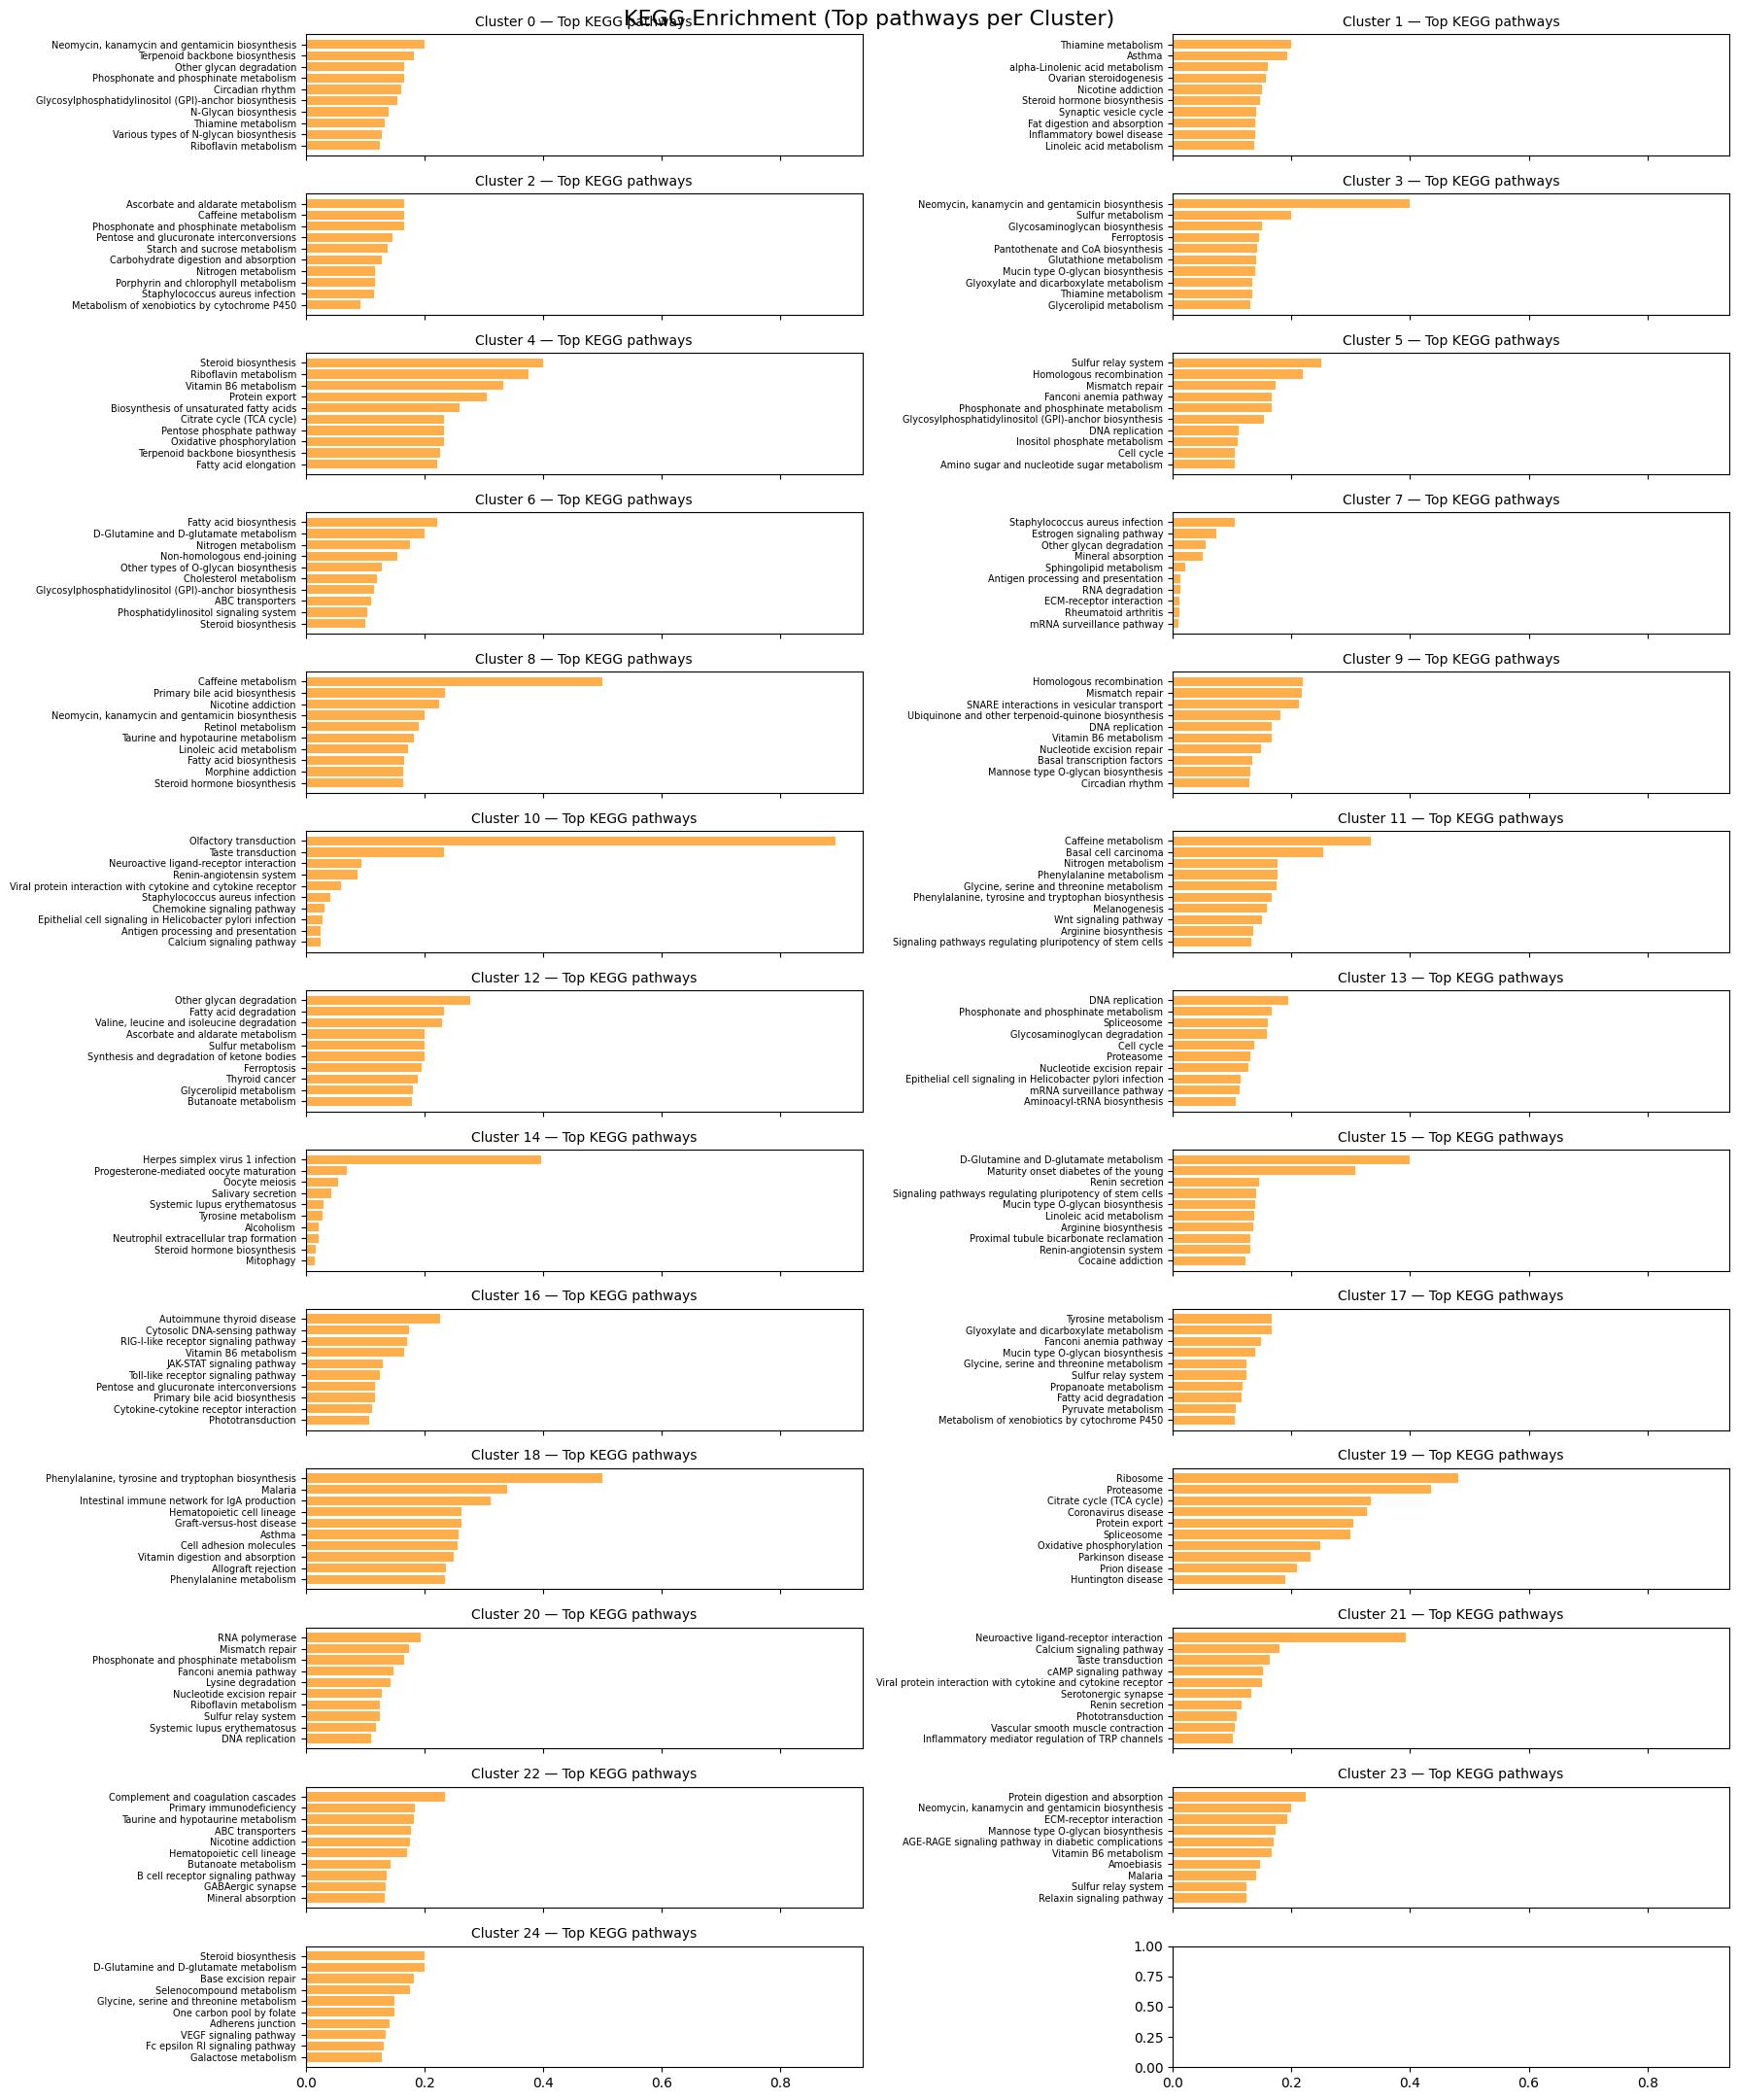

In [33]:
import matplotlib.pyplot as plt

# Compute top KEGG pathways per cluster
cluster_top_kegg = {}

for c in range(k):
    df = kegg_results[c].copy()
    df["rich_factor"] = compute_rich_factor(df)

    # keep top 10 KEGG terms
    df_top = df.nlargest(10, "rich_factor")
    cluster_top_kegg[c] = df_top

# Plot: 5 rows × 2 columns = 10 clusters
rows, cols = (k + 2) // 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(18, 22), sharex=True)

for idx, c in enumerate(range(k)):
    ax = axes[idx // cols][idx % cols]
    df = cluster_top_kegg[c]

    ax.barh(df["Term"], df["rich_factor"], color="darkorange", alpha=0.7)
    ax.set_title(f"Cluster {c} — Top KEGG pathways", fontsize=10)
    ax.invert_yaxis()  # largest factor at top
    ax.tick_params(axis='y', labelsize=7)

fig.suptitle("KEGG Enrichment (Top pathways per Cluster)", fontsize=16)
plt.tight_layout()
plt.show()


In [34]:
# Canonical squamous epithelial program markers
squamous_markers = [
    "KRT5","KRT6A","KRT6B","KRT6C","KRT14","KRT16","KRT17","KRT19",
    "DSC1","DSC2","DSG1","DSG2","DSG3",
    "JUP","PKP1","PKP3",
    "IVL","SPRR1A","SPRR1B","SPRR2A","SPRR2B",
    "LCE1A","LCE1B","LCE1C","LCE2A","LCE2B",
    "TP63","SOX2","GRHL3","ELF3"
]

# Keep only genes that exist in your expression dataset
squamous_present = [g for g in squamous_markers if g in gene_names]
print("Squamous markers present:", squamous_present)

squamous_gene_mask = np.array([1 if g in squamous_present else 0 for g in gene_names])


Squamous markers present: ['KRT5', 'KRT6A', 'KRT6B', 'KRT6C', 'KRT14', 'KRT16', 'KRT17', 'KRT19', 'DSC1', 'DSC2', 'DSG1', 'DSG2', 'DSG3', 'JUP', 'PKP1', 'PKP3', 'IVL', 'SPRR1A', 'SPRR1B', 'SPRR2A', 'SPRR2B', 'LCE1A', 'LCE1B', 'LCE1C', 'LCE2A', 'LCE2B', 'TP63', 'SOX2', 'GRHL3', 'ELF3']


/tmp/ipykernel_44082/226083126.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sq, x="cluster", y="squamous_markers", palette="viridis")


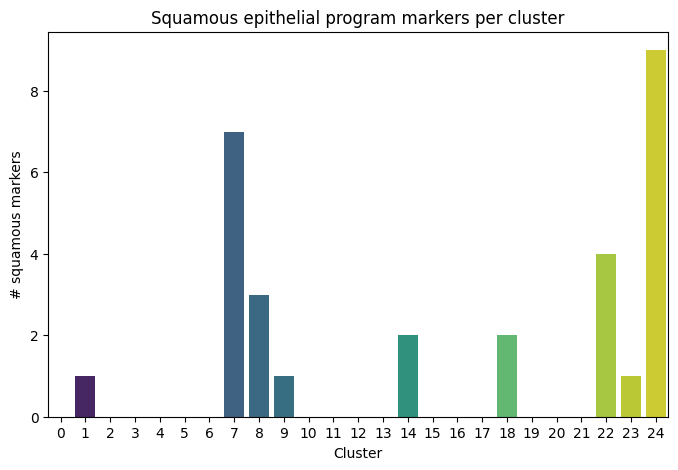

In [35]:
import pandas as pd
import seaborn as sns

cluster_squamous_counts = []

for c in range(k):
    cluster_indices = np.where(clusters == c)[0]
    genes_in_cluster = [gene_names[i] for i in cluster_indices]
    count = sum(1 for g in squamous_present if g in genes_in_cluster)
    cluster_squamous_counts.append(count)

df_sq = pd.DataFrame({
    "cluster": list(range(k)),
    "squamous_markers": cluster_squamous_counts
})

plt.figure(figsize=(8,5))
sns.barplot(data=df_sq, x="cluster", y="squamous_markers", palette="viridis")
plt.title("Squamous epithelial program markers per cluster")
plt.xlabel("Cluster")
plt.ylabel("# squamous markers")
plt.show()
